In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2

import numpy as np

import albumentations as albu
from albumentations.pytorch import ToTensorV2
import torch
from torchsummary import summary

from dataset import PneumoDataset
from model import ResUNet
from losses import dice_metric

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Exploration

## Load processed data

In [2]:
# Storing file path locally, change for your system
negative_images_path="./data/2img_mask_npy/negative_imgs.npy"
negative_masks_path="./data/2img_mask_npy/negative_masks.npy"
negative_names_path="./data/2img_mask_npy/negative_imgs_names.npy"

positive_images_path="./data/2img_mask_npy/positive_imgs.npy"
positive_masks_path="./data/2img_mask_npy/positive_masks.npy"
positive_names_path="./data/2img_mask_npy/positive_imgs_names.npy"

In [ ]:
negative_images = np.load(negative_images_path)
negative_masks = np.load(negative_masks_path)
negative_names = np.load(negative_names_path)

positive_images = np.load(positive_images_path)
positive_masks = np.load(positive_masks_path)
positive_names = np.load(positive_names_path)

## Plotting examples

In [2]:
def plt_img_mask(img, msk, ax):
    ax.imshow(img, cmap='gray')  # Call imshow on the axis
    ax.imshow(msk, cmap='jet', alpha=0.3)  # Overlay the mask
    ax.axis('off')  # Turn off the axis

fname: 1.2.276.0.7230010.3.1.4.8323329.5222.1517875187.61027.png
fname: 1.2.276.0.7230010.3.1.4.8323329.2583.1517875173.593347.png
fname: 1.2.276.0.7230010.3.1.4.8323329.338.1517875162.455978.png
fname: 1.2.276.0.7230010.3.1.4.8323329.2218.1517875171.672924.png
fname: 1.2.276.0.7230010.3.1.4.8323329.4509.1517875183.211958.png


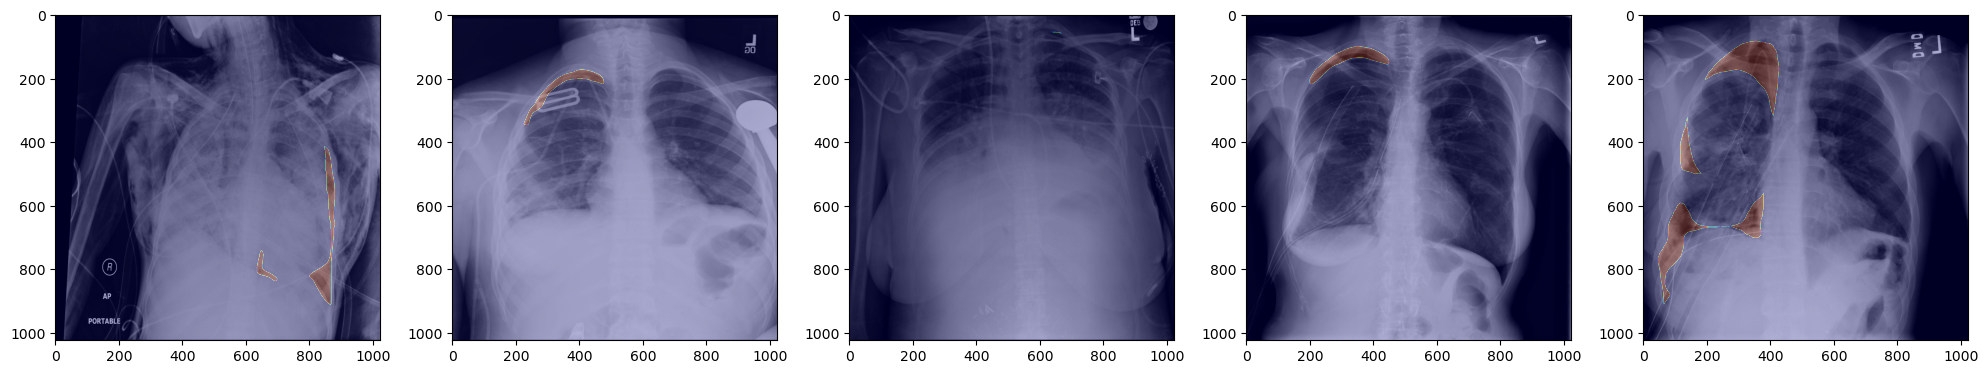

In [ ]:
# Plotting Positive Images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create a row of 5 subplots

for i in range(5):  # Loop over the 5 subplots
    plt_img_mask(positive_images[i], positive_masks[i], positive_names[i], axs[i])

plt.tight_layout()
plt.show()

fname: 1.2.276.0.7230010.3.1.4.8323329.4015.1517875180.661259.png
fname: 1.2.276.0.7230010.3.1.4.8323329.3895.1517875180.10946.png
fname: 1.2.276.0.7230010.3.1.4.8323329.32383.1517875160.322522.png
fname: 1.2.276.0.7230010.3.1.4.8323329.3909.1517875180.73776.png
fname: 1.2.276.0.7230010.3.1.4.8323329.13419.1517875245.240854.png


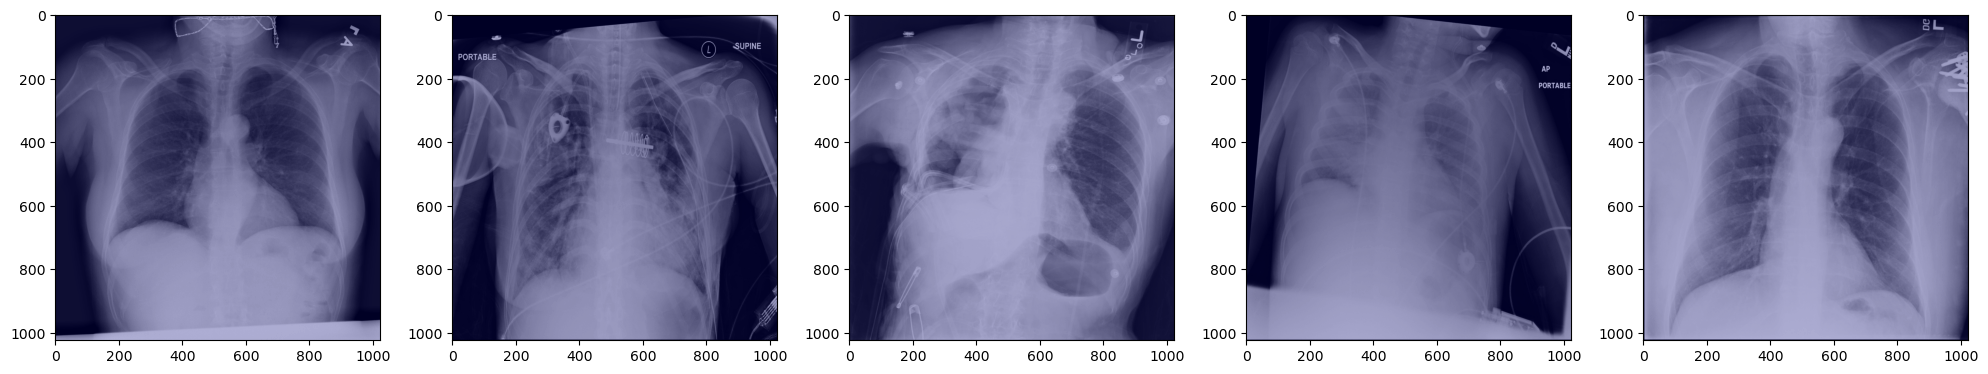

In [ ]:
# Plotting Negative Images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create a row of 5 subplots

for i in range(5):  # Loop over the 5 subplots
    plt_img_mask(negative_images[i], negative_masks[i], negative_names[i], axs[i])

plt.tight_layout()
plt.show()

## Data Augmentation Display

In [ ]:
positive_names = np.load("data/2img_mask_npy/positive_imgs_names.npy")
negative_names = np.load("data/2img_mask_npy/negative_imgs_names.npy")
train_names = np.concatenate((positive_names, negative_names))
print(f"Amount of positive samples: {len(positive_names)}")
print(f"Amount of negative samples: {len(negative_names)}")

Amount of positive samples: 2669
Amount of negative samples: 9378


In [ ]:
img_size = 512
train_transform = albu.Compose([
    albu.OneOf([
        albu.RandomGamma(),
        albu.RandomBrightnessContrast(),
        ], p=0.5),
    albu.OneOf([
        albu.ElasticTransform(),
        albu.GridDistortion(),
        albu.OpticalDistortion(),
        ], p=0.3),
    albu.ShiftScaleRotate(scale_limit=(0, 0.1), rotate_limit=0),
    albu.Resize(img_size, img_size, always_apply=True),
    # albu.Normalize()
])

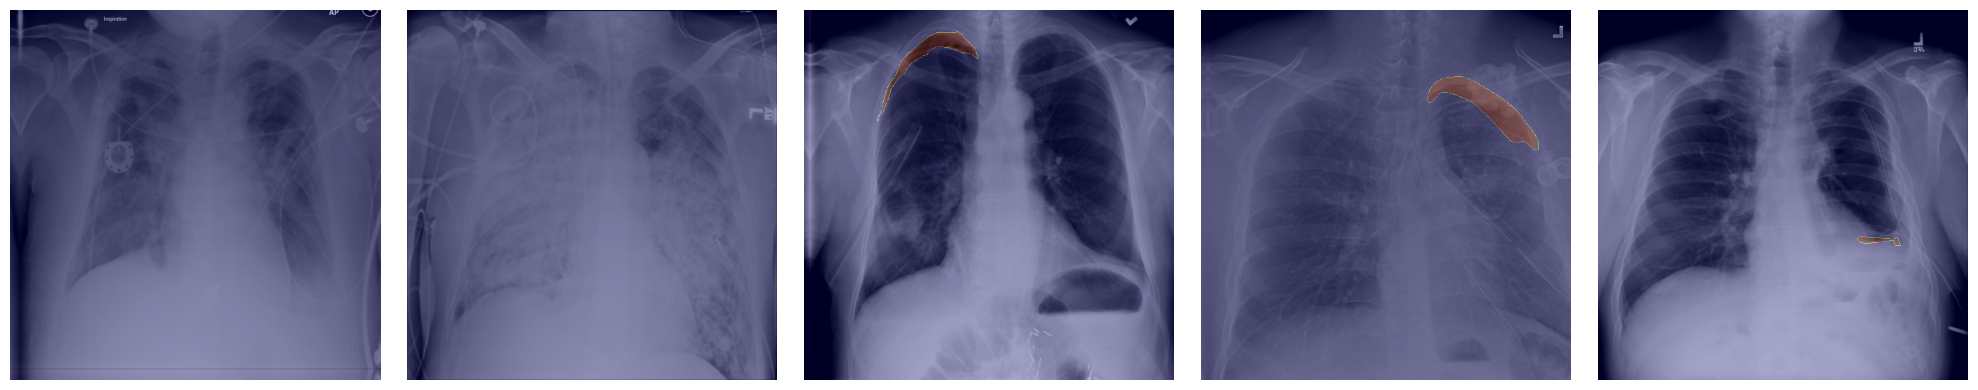

In [ ]:
fold_labels = np.load("./data/2img_mask_npy/fold_labels.npy")
train_dataset = PneumoDataset(mode="train", fold_index=0, 
                              train_names=train_names, fold_labels=fold_labels, transform=train_transform)

# Displaying 5 images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create a row of 5 subplots
img_idx = np.random.choice(len(train_dataset), 5)  # Get 5 random indices
for i in range(5):  # Loop over the 5 subplots
    img, msk = train_dataset[img_idx[i]]  # Get the image and mask
    img = img.numpy().transpose(1, 2, 0).astype(int)  # Transpose the image
    msk = msk.numpy().transpose(1, 2, 0)  # Transpose the mask
    plt_img_mask(img, msk, axs[i])  # Plot the image and mask

plt.tight_layout()
plt.show()

# Model Summary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResUNet(1, 32, pretrained=False)
model.to(device)

summary(model, (3, 1024, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           9,408
            Conv2d-2         [-1, 64, 512, 512]           9,408
       BatchNorm2d-3         [-1, 64, 512, 512]             128
       BatchNorm2d-4         [-1, 64, 512, 512]             128
              ReLU-5         [-1, 64, 512, 512]               0
              ReLU-6         [-1, 64, 512, 512]               0
         MaxPool2d-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9         [-1, 64, 256, 256]          36,864
           Conv2d-10         [-1, 64, 256, 256]          36,864
      BatchNorm2d-11         [-1, 64, 256, 256]             128
      BatchNorm2d-12         [-1, 64, 256, 256]             128
             ReLU-13         [-1, 64, 256, 256]               0
             ReLU-14         [-1, 64, 2

# Training Results Display

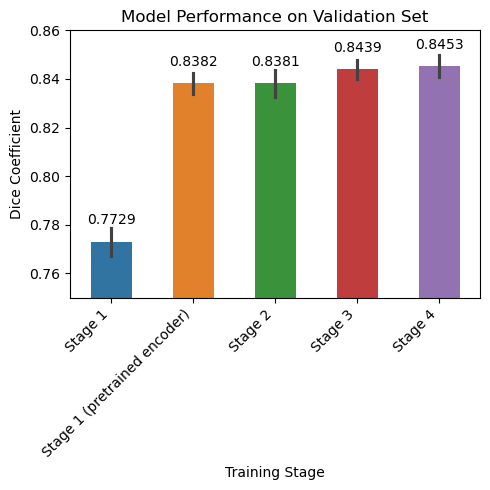

In [23]:
import pandas as pd
import seaborn as sns

resunet_512 = np.array([0.77097, 0.77636, 0.78127, 0.76807, 0.76795])
resunet_512_pretrained = np.array([0.84251, 0.84001, 0.831, 0.83712, 0.84021])
resunet_1024_1 = np.array([0.83456, 0.84657, 0.8322, 0.838, 0.83941])
resunet_1024_2 = np.array([0.84518, 0.84564, 0.8372, 0.8444, 0.84709])
resunet_1024_3 = np.array([0.84909, 0.84507, 0.8383, 0.84433, 0.84956])
labels = ["Stage 1", "Stage 1 (pretrained encoder)", "Stage 2", "Stage 3", "Stage 4"]

values = np.concatenate([resunet_512, 
                         resunet_512_pretrained, 
                         resunet_1024_1, 
                         resunet_1024_2, 
                         resunet_1024_3])
labels = np.repeat(labels, [len(resunet_512), 
                            len(resunet_512_pretrained), 
                            len(resunet_1024_1), 
                            len(resunet_1024_2), 
                            len(resunet_1024_3)])
plot_df = pd.DataFrame({"Label": labels, "Value": values})

plt.figure(figsize=(5, 5))
ax = sns.barplot(data=plot_df,
                x="Label",
                y="Value",
                errorbar="sd",
                hue="Label",
                legend=False,
                width=0.5)
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.006, f'{height:.4f}', 
                ha='center', va='bottom', fontsize=10)
        
plt.title("Model Performance on Validation Set")
plt.xlabel("Training Stage")
plt.ylabel("Dice Coefficient")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.75, 0.86)
plt.tight_layout()
plt.show()

# Inference on Validation Set

In [93]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [94]:
fold_index = 0
model = ResUNet(pretrained=False)
model_path = f"experiments/resunet/resunet_1024_3/resunet_1024_fold{fold_index}.pth"
model.load_state_dict(torch.load(model_path))
model.to(device)

C:\Users\tommy\AppData\Local\Temp\ipykernel_5680\385001219.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


ResUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [97]:
positive_names = np.load("data/2img_mask_npy/positive_imgs_names.npy")
negative_names = np.load("data/2img_mask_npy/negative_imgs_names.npy")
fold_labels = np.load("data/2img_mask_npy/fold_labels.npy")
positive_fold_labels = fold_labels[:len(positive_names)]
negative_fold_labels = fold_labels[len(positive_names):]
display_names = np.concatenate([np.random.choice(positive_names[positive_fold_labels == fold_index], 5), 
                                np.random.choice(negative_names[negative_fold_labels == fold_index], 5)])

valid_transform = albu.Compose([
    albu.Resize(1024, 1024, always_apply=True),
    albu.Normalize()
])

top_score_threshold = 0.6
area_threshold = 3000
bottom_score_threshold = 0.25

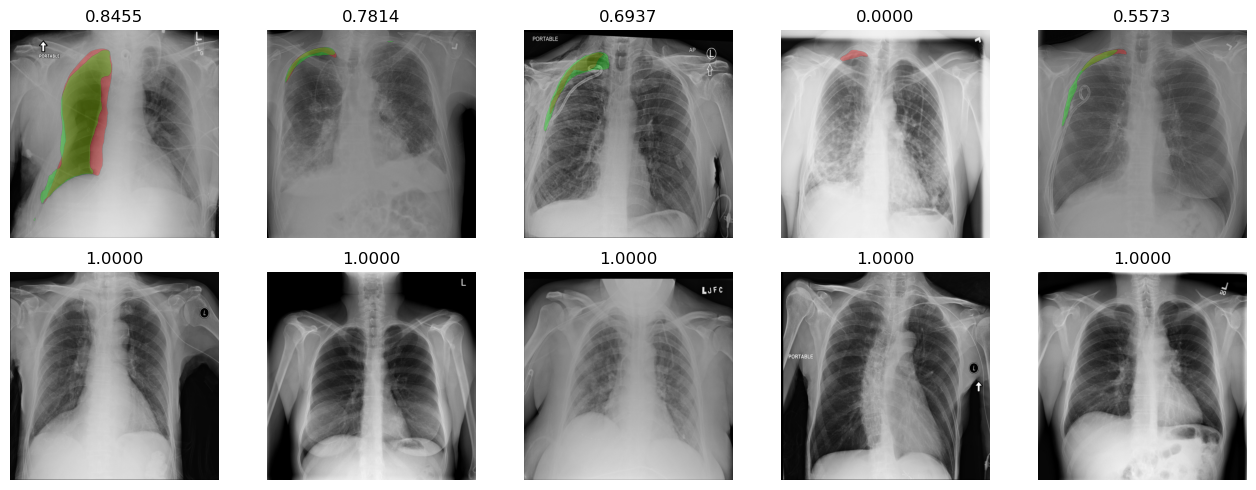

In [101]:
fig, axs = plt.subplots(2, 5, figsize=(13, 5))
red_cmap = LinearSegmentedColormap.from_list("red", [(0, 0, 0, 0), (1, 0, 0, 1)], N=256)
green_cmap = LinearSegmentedColormap.from_list("green", [(0, 0, 0, 0), (0, 1, 0, 1)], N=256)

for index, display_name in enumerate(display_names):
    img_path = f"data/1img_mask/images/{display_name}"
    msk_path = f"data/1img_mask/mask/{display_name}"
    img = cv2.imread(img_path, 1)
    msk = cv2.imread(msk_path, 0)
    
    sample = {"image": img, "mask": msk}
    sample = valid_transform(**sample)
    sample = ToTensorV2()(**sample)
    img_model, msk_model = sample["image"].unsqueeze(0).to(device), sample["mask"].unsqueeze(0).unsqueeze(0).to(device) / 255.
    
    model.eval()
    with torch.no_grad():
        pred = model(img_model)
        pred = torch.sigmoid(pred)
        clf = pred > top_score_threshold
        pred = pred > bottom_score_threshold
        pred[clf.sum(dim=(2,3)) < area_threshold] = 0
    score = dice_metric(pred, msk_model, per_image=True).detach().cpu().numpy()
    pred = pred.squeeze().cpu().numpy() * 255

    axs[index//5, index%5].imshow(img, cmap='gray')
    axs[index//5, index%5].imshow(msk, cmap=red_cmap, alpha=0.3)
    axs[index//5, index%5].imshow(pred, cmap=green_cmap, alpha=0.3)
    axs[index//5, index%5].axis('off')
    axs[index//5, index%5].set_title(f"{score:.4f}")
plt.tight_layout()
plt.savefig("figures/fig4.2.svg")